# TopoVelo Plotting Function Usage
This notebook introduces different types of plotting functions in the topovelo package. We assume the users have already run the entire training pipeline in example.ipynb

In [1]:
import numpy as np
import scanpy as sc
import scvelo as scv
import topovelo as tpv
import matplotlib.pyplot as plt
#%load_ext autoreload
#%autoreload 2

## Part 0: read the output after training TopoVelo
Here, we load an AnnData with saved results and a VAE model with previously saved model parameters.

In [2]:
dataset = 'slide-seq-adult-cortex'
data_path = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/data/topovelo/slide-seq-brain-cortex'
figure_path = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/figures/{dataset}/gat'
model_path = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/topovelo_model/{dataset}/gat'

adata = sc.read(f'{data_path}/adata_out.h5ad')

## Part 1: General Plotting
TopoVelo provides a function `post_analysis` that performs both model evaluation and plotting. Please see `evaluation.ipynb` for details of evaluation. As for plotting, the function can generate the following plots:
1. **Scatter plot** colored by cell clusters.
2. **Time heatmap**: scatter plot with each cell is colored by its developmental time inferred by TopoVelo
3. **Phase portrait**: scatter plot of observed and predicted u/s on a 2D plane. We note that this is helpful for visualizing simple ODE solutions with a single trajectory.
4. **Gene plot**: scatter plot with time as the x-axis and observed/predicted u/s as the y axis. Users can provide a list of genes to plot.
5. **Velocity stream**: the function acts as a wrapper of scVelo's `velocity_graph`, `velocity_embedding` and `velocity_embedding_stream` functions.

For each type of plot, we can pass a dictionary containing all parameters for the plot, e.g. title fontsize, legend fontsize, etc. There is bit learning curve here, but once you know what parameter to pass, you can customize your plot arbitrarily :)

### Step 1: set plotting configurations
Each type of plot has its own configurations. You don't have to set everything as there is always a default.
Some notes:
1. If `real_aspect_ratio` is set to True, the figure size will be automatically adjusted as (width, width * aspect_ratio) so that the height parameter no longer take effect. 
2. For the stream plot, `density` controls the density of the stream lines. Please refer to [scVelo](https://scvelo.readthedocs.io/en/stable/scvelo.pl.velocity_embedding_stream.html#scvelo.pl.velocity_embedding_stream) for more details.

In [3]:
# define genes to plot
genes = tpv.sample_genes(adata, 4, 'highly_variable')

# compute figure size based on real aspect ratio
width = 4
figsize = tpv.compute_figsize(adata.obsm['X_spatial'], real_aspect_ratio=True, width=width)

cluster_plot_config={
    'figsize': figsize,
    'real_aspect_ratio':True
}
phase_plot_config={
    'width': 4
}
gene_plot_config={
    'width': 4
}
time_plot_config={
    'width': 4,
    'color_map': 'viridis',
}


stream_plot_config={
    'width': figsize[0],
    'height': figsize[1],
    'markersize': 100,
    'density': 2,
    'linewidth': 2,
}

To save time, we set `compute_metrics=False` to skip performance evaluation.

['Map2']
Computing a spatial graph using KNN on X_spatial with k=50
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
---   Plotting  Results   ---
computing velocity graph (using 1/32 cores)


  0%|          | 0/2525 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)


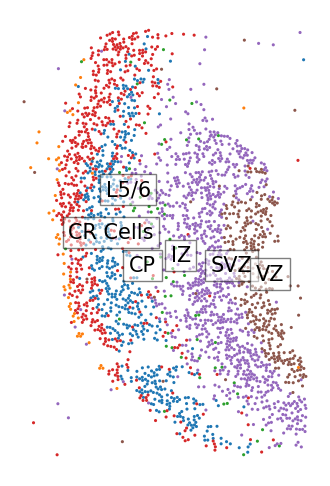

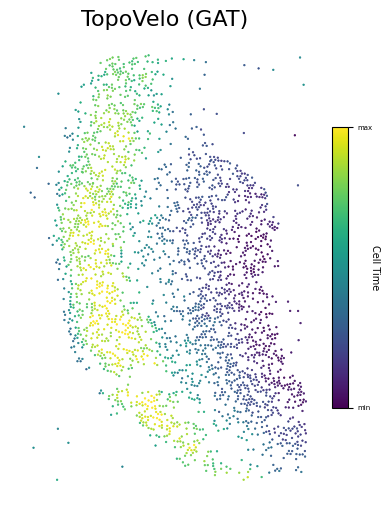

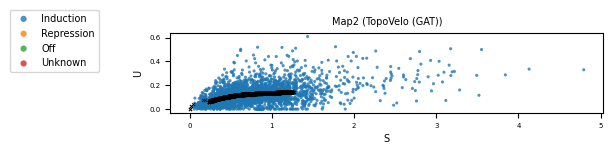

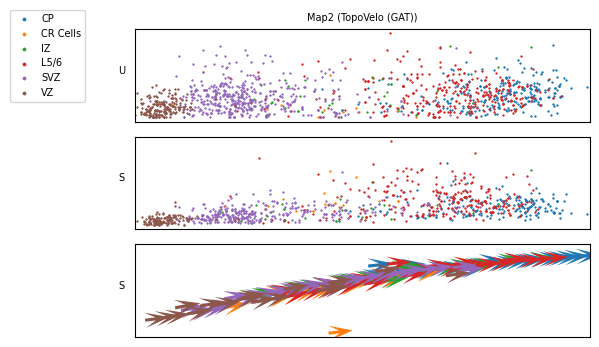

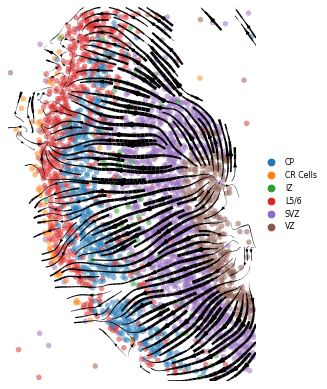

(None, None, None, None)

In [4]:
tpv.post_analysis(adata,
                  'cortex',
                  ['TopoVelo (GAT)'],
                  ['gat'],
                  spatial_velocity_graph=True,
                  n_spatial_neighbors=50,
                  spatial_key='X_spatial',
                  spatial_graph_key='spatial_graph',
                  compute_metrics=False,
                  embed='spatial',
                  cluster_plot_config=cluster_plot_config,
                  phase_plot_config=phase_plot_config,
                  gene_plot_config=gene_plot_config,
                  time_plot_config=time_plot_config,
                  stream_plot_config=stream_plot_config,
                  plot_type=['time', 'gene', 'phase', 'cluster', 'cell velocity'])

## Part 2: Cell Influence Score
The cell influence score is defined as $$a_i = \frac{1}{k}\sum_{h=1}^{k}\sum_{j=1}^{N} att_{ij}^{(h)}$$
where $att_{ij}$ is the attention from cell $i$ to $j$. 

The cell influence score requires all-to-all attention, which is beyond local neighborhood in graph attention.

### Step 1: Reload a trained model.
When we create a VAE object, we can load previously trained model parameters by setting `checkpoints`. It contains a list of two file paths. The first one is for the encoder and the second one for the decoder.

In [7]:
vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              hidden_size=(50, 25, 50),
              device='cuda:0',
              checkpoints=[f'{model_path}/encoder.pt',
                           f'{model_path}/decoder.pt'])

### Step 2: Calculate all-to-all attention scores.

In graph attention, we only consider the attention scores from directly connected neighbors. However, we refer the cell influence score as the total attention score from a source cell. Hence, we need to recompute the attention scores using `get_enc_att_all_pairs`. 

It takes all unspliced and spliced counts as graph node features. We need to first convert numpy arrays to tensors on cuda devices before calling the function. In addition, the `batch_size` argument helps relieve memory consumption by computing all-to-batch attentions scores iteratively. 

In [17]:
import torch
# data conversion
data = np.concatenate([adata.layers['Mu'], adata.layers['Ms']], 1)
data = torch.tensor(data).float().to(vae.device)
# calculate cell influence score
att_enc = vae.get_enc_att_all_pairs(data, adata.n_obs, batch_size=128)
att_src = att_enc.mean(2).sum(1)

### Visualization

We can use `tpv.plotting.plot_heat_density` to visualize the cell influence score on spatial coordinates. Instead of directly coloring each cell by its score, we found it more clear to use a density plot showing the region with highest cell influence score. We can adjust many details about plotting using keyword arguments.

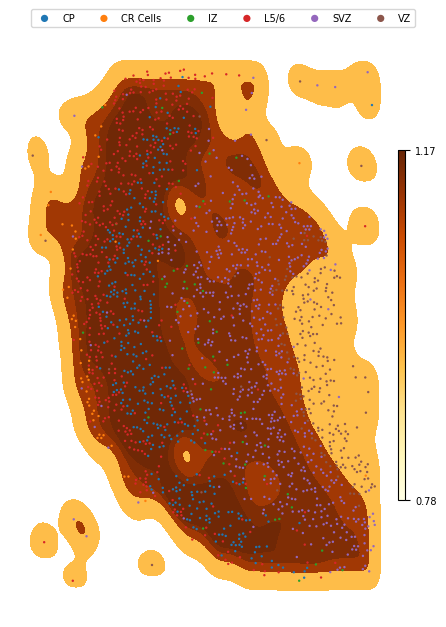

In [19]:
cell_labels = adata.obs['clusters'].to_numpy()
tpv.plotting.plot_heat_density(att_src,
                               adata.obsm['X_spatial'],
                               width=5,
                               height=6,
                               radius=0.02,
                               cell_labels=cell_labels,
                               n_grid=50,
                               levels=5,
                               ncols=6,
                               bbox_to_anchor=[0.15, 1, 0.8, 0.05],
                               legend_fontsize=7,
                               cmap='YlOrBr',
                               markersize=3,
                               markerscale=3,
                               colorbar_name='',
                               colorbar_pos=[1.0, 0.2, 0.02, 0.6],
                               colorbar_tick_fontsize=7,
                               colorbar_labelpad=0,
                               colorbar_fontsize=12,
                               sample_per_bin=5,
                               bw_adjust=0.3,
                               save=f'{figure_path}/cell_influence_score.png')